In [20]:
# Run code on Anaconda Env.
# Construct data source by downloading 2018 data
import folktables
from folktables import ACSDataSource, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import statistics

data_source = ACSDataSource(survey_year='2015', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)  # have to use 'download=True' if data not already avaiable locally

features, label, group = ACSIncome.df_to_numpy(acs_data)  # split data into corresponding (selected) features, labels, and group
''' 
ASCIncome features:

AGEP
COW
SCHL
MAR
OCCP
POBP
RELP
WKHP
SEX
RAC1P
'''


# get total number of BHN in dataset
totalBHN = len(np.where((group == 2) | (group == 3))[0])
print("total BHN in dataset: ", totalBHN)

# fix training set size to 0.5 * totalBHN, round to nearest multiple of 100
fixed_train_size = int(round(0.5 * totalBHN, -2))
print("fixed training set size: ", fixed_train_size)



total BHN in dataset:  9794
fixed training set size:  4900


In [22]:
def mixRaceRates(data, num_bhn):
    # get indicies of all BHN data
    rac1p_values = data[:, 9]
    bhn_rows = np.where((rac1p_values == 2) | (rac1p_values == 3))[0]

    # sample num_bhn from data set
    np.random.shuffle(bhn_rows)
    sample_bhn_indicies = bhn_rows[:num_bhn]
    
    # extract the bhn rows from the data set
    sampled_bhn = data[sample_bhn_indicies, :]

    # sample remaining amount of data to reach fixed_train_size
    non_bhn_rows = np.where((rac1p_values != 2) & (rac1p_values != 3))[0]
    np.random.shuffle(non_bhn_rows)
    num_non_bhn = fixed_train_size - num_bhn
    sample_non_bhn_indicies = non_bhn_rows[:num_non_bhn]

    # extract the non-bhn rows from the data set
    sampled_non_bhn = data[sample_non_bhn_indicies, :]

    # concatenate the extracted datasets together to create modified dataset
    modified_data = np.concatenate((sampled_bhn, sampled_non_bhn), axis=0)

    '''
    print("initial training size: ", len(data))
    print("modified training size: ", len(modified_data))
    print("# bhn sampled: ", len(np.where((modified_data[:, 9] == 2) | (modified_data[:, 9] == 3))[0]))
    print("# non-bhn sampled: ", len(np.where((modified_data[:, 9] != 2) & (modified_data[:, 9] != 3))[0]))
    '''

    return modified_data


In [23]:
def confusion(pred, label):
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    acc = (tp + tn)/ (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    fnr = fn / (tp + fn)
    fpr = fp / (fp + tn)
    tnr = tn / (fp + tn)
    return [acc, tpr, fnr, fpr, tnr]

def evaluateMixRate(features, label, group, num_bhn):
    num_iterations = 10
    wa_data = [[] for _ in range(num_iterations)]
    bhn_data = [[] for _ in range(num_iterations)]

    for i in range(num_iterations):
        # randomly split the data into training and testing
        # train-test split: 80/20
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
            features, label, group, test_size=0.2)

        # reshape y_train into column vector, then concatenate with X_train to reformat training data
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)

        # filter training data to satisfy desired BHN mix rate
        modified_train_data = mixRaceRates(train_data, num_bhn)

        new_X_train = modified_train_data[:, :-1] # get all cols except for last one
        new_y_train = modified_train_data[:, -1]  # get only the last col

        # create the pipeline: normalize data, then use logistic regression as classifier
        model = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=16, min_samples_leaf=3))
        # train the model with the training data
        model.fit(new_X_train, new_y_train)

        # make predictions on test data set
        yhat = model.predict(X_test)
        yhat_wa = yhat[(group_test == 1) | (group_test == 6)]  # all rows from prediction where group=1 (white) or group=6 (asian)
        yhat_bhn = yhat[(group_test == 2) | (group_test == 3)]  # all rows from prediction where group=2 (black) or group=3 (american indian)

        y_test_wa = y_test[(group_test == 1) | (group_test == 6)]  # all rows from test set where group=1 (white) or group=6 (asian)
        y_test_bhn = y_test[(group_test == 2) | (group_test == 3)]  # all rows from test set where group=2 (black) or group=3 (american indian)
        
        # get the acc, tpr, fnr, fpr, tnr data for WA and BHN groups
        wa_data_i = confusion(yhat_wa, y_test_wa)       # [acc, tpr, fnr, fpr, tnr]
        bhn_data_i = confusion(yhat_bhn, y_test_bhn)    # [acc, tpr, fnr, fpr, tnr]

        # append data of this iteration into accumulated dataset
        wa_data[i] = wa_data_i
        bhn_data[i] = bhn_data_i
    
   
    # compute the average and std. dev for the output data
    avg_wa_data = []
    avg_bhn_data = []
    
    for i in range(5):
        waData = [row[i] for row in wa_data]
        bhnData = [row[i] for row in bhn_data]
        avg_wa_data.append([statistics.mean(waData), statistics.stdev(waData)])
        avg_bhn_data.append([statistics.mean(bhnData), statistics.stdev(bhnData)])
        
    
    return avg_wa_data, avg_bhn_data
    # return data as [ACC(avg, stddev), TPR(avg, stddev), FNR(avg, stddev), FPR(avg, stddev), TNR(avg, stddev)]

In [24]:
target_bhn_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

# for each mix rate, run the prediction task x times and take the average as the 
# prediction output for that mix rate

# map: % bhn in training set -> [ACC(avg, stddev), TPR(avg, stddev), FNR(avg, stddev), FPR(avg, stddev), TNR(avg, stddev)]
wa_map = {}
bhn_map = {}

for target_rate in target_bhn_rates:
    print("\nmix rate: ", target_rate)
    num_bhn = int(target_rate * fixed_train_size)
    wa_data, bhn_data = evaluateMixRate(features, label, group, num_bhn)
    wa_map[target_rate] = wa_data
    bhn_map[target_rate] = bhn_data

# print results
for i in range(len(target_bhn_rates)):
    target_rate = target_bhn_rates[i]
    print("\n% BHN in training set: ", target_rate * 100)
    print("Accuracy (WA): ", wa_map[target_rate][0])
    print("TPR (WA): ", wa_map[target_rate][1])
    print("FNR (WA): ", wa_map[target_rate][2], " (Pessimistic Underestimation)")
    print("FPR (WA): ", wa_map[target_rate][3], " (Benefit of Doubt)")
    print("TNR (WA): ", wa_map[target_rate][4])

    print("\nAccuracy (BHN): ", bhn_map[target_rate][0])
    print("TPR (BHN): ", bhn_map[target_rate][1])
    print("FNR (BHN): ", bhn_map[target_rate][2], " (Pessimistic Underestimation)")
    print("FPR (BHN): ", bhn_map[target_rate][3], " (Benefit of Doubt)")
    print("TNR (BHN): ", bhn_map[target_rate][4])


mix rate:  1

mix rate:  0.9

mix rate:  0.8

mix rate:  0.7

mix rate:  0.6

mix rate:  0.5

mix rate:  0.4

mix rate:  0.3

mix rate:  0.2

mix rate:  0.1

mix rate:  0

% BHN in training set:  100
Accuracy (WA):  [0.7914332760077051, 0.0027338254632761315]
TPR (WA):  [0.6590213320875888, 0.011434987421792041]
FNR (WA):  [0.34097866791241116, 0.011434987421792052]  (Pessimistic Underestimation)
FPR (WA):  [0.11814172887677948, 0.005746949046151867]  (Benefit of Doubt)
TNR (WA):  [0.8818582711232206, 0.00574694904615186]

Accuracy (BHN):  [0.8131674276948908, 0.008766283744286242]
TPR (BHN):  [0.6233399424793232, 0.02100327845560038]
FNR (BHN):  [0.37666005752067677, 0.02100327845560036]  (Pessimistic Underestimation)
FPR (BHN):  [0.10337323789747271, 0.009852461640430781]  (Benefit of Doubt)
TNR (BHN):  [0.8966267621025272, 0.009852461640430792]

% BHN in training set:  90.0
Accuracy (WA):  [0.7938590627527751, 0.00275695445093735]
TPR (WA):  [0.6856547099032184, 0.01564511422522219

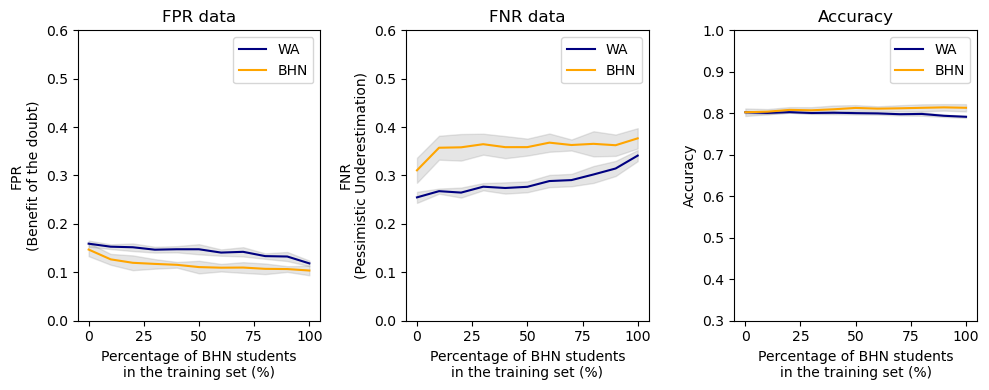

In [25]:
import matplotlib.pyplot as plt


x = [] 
y_FPR_WA = []
y_FPR_BHN = []
y_FNR_WA = []
y_FNR_BHN = []
y_ACC_WA = []
y_ACC_BHN = []

fpr_wa_stddev = []
fpr_bhn_stddev = []
fnr_wa_stddev = []
fnr_bhn_stddev = []
acc_wa_stddev = []
acc_bhn_stddev = []

for mix_rate in target_bhn_rates:
    x.append(mix_rate * 100)

    y_FPR_WA.append(wa_map[mix_rate][3][0])
    y_FPR_BHN.append(bhn_map[mix_rate][3][0])
    fpr_wa_stddev.append(wa_map[mix_rate][3][1])
    fpr_bhn_stddev.append(bhn_map[mix_rate][3][1])

    y_FNR_WA.append(wa_map[mix_rate][2][0])
    y_FNR_BHN.append(bhn_map[mix_rate][2][0])
    fnr_wa_stddev.append(wa_map[mix_rate][2][1])
    fnr_bhn_stddev.append(bhn_map[mix_rate][2][1])

    y_ACC_WA.append(wa_map[mix_rate][0][0])
    y_ACC_BHN.append(bhn_map[mix_rate][0][0])
    acc_wa_stddev.append(wa_map[mix_rate][0][1])
    acc_bhn_stddev.append(bhn_map[mix_rate][0][1])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# plot data
ax1.plot(x, y_FPR_WA, label="WA", color="navy")
ax1.plot(x, y_FPR_BHN, label="BHN", color="orange")
ax1.fill_between(x, [y - s for y, s in zip(y_FPR_WA, fpr_wa_stddev)], [y + s for y, s in zip(y_FPR_WA, fpr_wa_stddev)], color='gray', alpha=0.2)
ax1.fill_between(x, [y - s for y, s in zip(y_FPR_BHN, fpr_bhn_stddev)], [y + s for y, s in zip(y_FPR_BHN, fpr_bhn_stddev)], color='gray', alpha=0.2)


ax2.plot(x, y_FNR_WA, label="WA", color="navy")
ax2.plot(x, y_FNR_BHN, label="BHN", color="orange")
ax2.fill_between(x, [y - s for y, s in zip(y_FNR_WA, fnr_wa_stddev)], [y + s for y, s in zip(y_FNR_WA, fnr_wa_stddev)], color='gray', alpha=0.2)
ax2.fill_between(x, [y - s for y, s in zip(y_FNR_BHN, fnr_bhn_stddev)], [y + s for y, s in zip(y_FNR_BHN, fnr_bhn_stddev)], color='gray', alpha=0.2)


ax3.plot(x, y_ACC_WA, label="WA", color="navy")
ax3.plot(x, y_ACC_BHN, label="BHN", color="orange")
ax3.fill_between(x, [y - s for y, s in zip(y_ACC_WA, acc_wa_stddev)], [y + s for y, s in zip(y_ACC_WA, acc_wa_stddev)], color='gray', alpha=0.2)
ax3.fill_between(x, [y - s for y, s in zip(y_ACC_BHN, acc_bhn_stddev)], [y + s for y, s in zip(y_ACC_BHN, acc_bhn_stddev)], color='gray', alpha=0.2)

# add labels and title
ax1.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax1.set_ylabel("FPR\n(Benefit of the doubt)")
ax1.set_title("FPR data")
ax1.legend()
ax1.set_ylim(0, 0.6)

ax2.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax2.set_ylabel("FNR\n(Pessimistic Underestimation)")
ax2.set_title("FNR data")
ax2.legend()
ax2.set_ylim(0, 0.6)

ax3.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax3.set_ylabel("Accuracy")
ax3.set_title("Accuracy")
ax3.legend()
ax3.set_ylim(0.3, 1)

plt.tight_layout()
plt.show()
